# Kolmogorov Smirnov Test (Adapted for Multiple Dimensions)

En este cuaderno abordamos la detección de *data drift* en datos multivariantes aplicando la prueba **Kolmogorov–Smirnov (KS)** por dimensión y agregando resultados. Al ser unidimensional, ejecutamos KS en cada dimensión y resumimos la evidencia combinando las **magnitudes** y **p-valores** mediante la **mediana** (alternativas: máximo de *D*, combinación tipo Fisher/Stouffer). Para controlar comparaciones múltiples en varias dimensiones usamos **Bonferroni**, que consiste en dividir el umbral de p-valor entre el número de dimensiones que tienen los datos. Como limitación, evaluar por dimensión puede pasar por alto cambios puramente conjuntos; para dependencias complejas se recomiendan métodos multivariantes como **MMD**, *energy distance* o *classifier two-sample tests*.


In [ ]:
# Para este notebook hay que tener instalado numpy, scikit-learn, matplotlib y frouros

import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt

from frouros.detectors.data_drift import KSTest


In [48]:
# El data drift busca determinar si dos conjuntos de datos pertenecen a una misma distribución. Es decir, si son similares.
# Esto requiere no solo medir la diferencia entre los dos conjuntos de datos, sino saber si la diferencia es significativa
# y no un fruto del azar.
#
# En este caso usaremos la prueba de Kolmogorov–Smirnov (KS) para dos muestras. KS compara las funciones de distribución
# empíricas de ambos conjuntos y toma como magnitud la mayor diferencia absoluta entre ellas. A esta magnitud se le llama D.
#
# Para saber si la diferencia es significativa no necesitamos teses de permutación: KS proporciona un p-valor analítico
# (o con aproximaciones estándar) a partir de D y de los tamaños de muestra. Este p-valor nos dice la probabilidad de
# observar una D al menos tan grande si ambos conjuntos provinieran de la misma distribución.
#
# Interpretación:
# - Cuanto mayor es D, mayor evidencia de cambio entre distribuciones.
# - Cuanto menor es el p-valor, más significativo es el drift (menos probable que sea fruto del azar).
#
# Por eso, antes de empezar los experimentos hay que definir un umbral (nivel de significación) para el p-valor.
# Lo más estándar en la literatura es usar 0.05.
#
# En este caso, como estamos trabajando en un entorno multi dimensional, se tiene que aplicar la corrección de Bonferroni.
# Esto consiste en tomar como TRESHOLD el valor que aplicariamos sobre una dimensión pero dividido entre el número de dimensiones.
# Esto quiere decir que, para este caso, como trabajamos con dos dimensiones debemos establecer como TRESHOLD 0.05/2.
TRESHOLD= 0.05/2

In [ ]:
# Como vamos a ver la detección de data drift con varios conjuntos de datos lo hemos instanciado como un metodo.
# Recibirá un sample_a como conjunto de datos de referencia y un sample_b como el de test.
# En este caso al ser aplicado a varias dimensiones hay que realizar alguna modificación sobre el método clásico.
# En primer lugar hay que aplicarlo a cada dimensión por separado. Después, agregar las medidas mediante alguna técnica
# estadística. En este caso, y siguiendo buenas prácticas, aplicamos la mediana para agrupar las diferentes medidas de drift.

def ks_multidimensional_drift_computation(sample_a, sample_b):
    assert sample_a.shape[1] == sample_b.shape[1]

    magnitudes= []
    p_values= []
    for dimension in range(sample_a.shape[1]):

        # Instanciamos el detector de drift KS
        detector= KSTest()

        # Lo ajustamos con los datos de la muestra de referencia
        detector.fit(sample_a[:,dimension])

        # Medimos la diferencia con los datos de test
        result= detector.compare(X=sample_b[:,dimension])[0]
        
        # Guardamos la magnitud y p_value para cada dimension
        magnitudes.append(result.statistic)
        p_values.append(result.p_value)

    # Devolvemos los datos agregando los resultados. 
    # Se pueden utilizar diferentes métricas, pero la más representativa suele ser la mediana.
    return np.median(magnitudes), np.median(p_values)
    

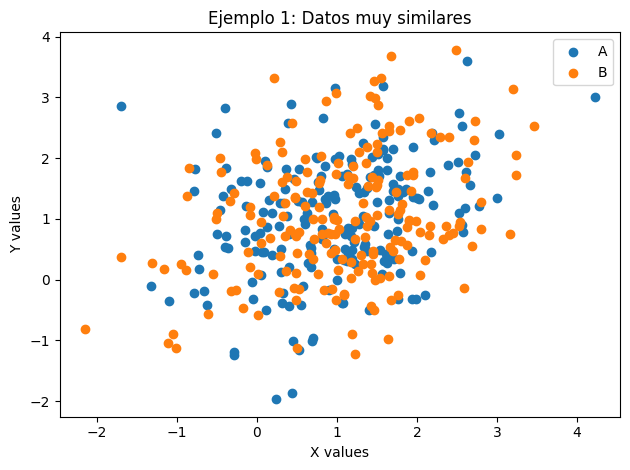

Magnitud del drift: 0.08 
p_value: 0.5473585965035915 
Es significativo? False


In [50]:
# Ejemplo 1: Datos muy similares

# Instanciamos dos Conjuntos de datos muy similares que vamos a visualizar
A= np.random.multivariate_normal(mean=(1,1), cov=((1.0, 0.3), (0.3, 1.0)), size=200)
B= np.random.multivariate_normal(mean=(1,1), cov=((1.0, 0.3), (0.3, 1.0)), size=200)

plt.figure()

plt.title("Ejemplo 1: Datos muy similares")

plt.scatter(A[:,0], A[:,1], label="A")
plt.scatter(B[:,0], B[:,1], label="B")
plt.xlabel("X values")
plt.ylabel("Y values")
plt.legend()
plt.tight_layout()
plt.show()

# Y ahora calculamos el data drift entre ambos conjuntos
drift= ks_multidimensional_drift_computation(A, B)

# Como son datos muy similares, la magnitud del drift que nos esperamos es muy baja.
# Además no esperamos que se encuentren diferencias significativas.

print(f"Magnitud del drift: {drift[0]} \np_value: {drift[1]} \nEs significativo? {drift[1] <= TRESHOLD}")

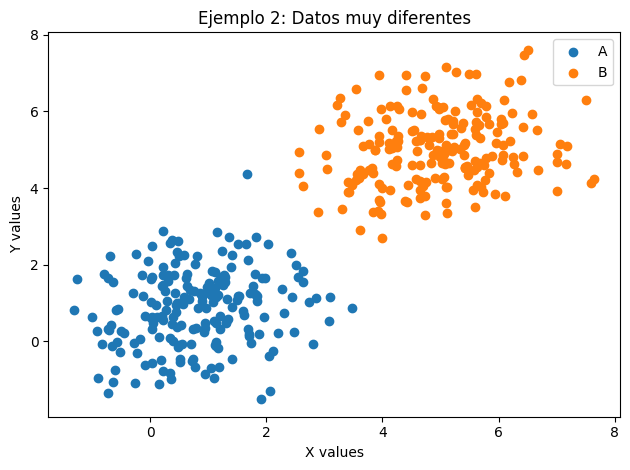

Magnitud del drift: 0.98 
p_value: 5.321442326503968e-107 
Es significativo? True


In [51]:
# Ejemplo 2: Datos muy diferentes

# Instanciamos dos Conjuntos de datos diferentes que vamos a visualizar
A= np.random.multivariate_normal(mean=(1,1), cov=((1.0, 0.3), (0.3, 1.0)), size=200)
B= np.random.multivariate_normal(mean=(5,5), cov=((1.0, 0.3), (0.3, 1.0)), size=200)

plt.figure()

plt.title("Ejemplo 2: Datos muy diferentes")

plt.scatter(A[:,0], A[:,1], label="A")
plt.scatter(B[:,0], B[:,1], label="B")
plt.xlabel("X values")
plt.ylabel("Y values")
plt.legend()
plt.tight_layout()
plt.show()

# Y ahora calculamos el data drift entre ambos conjuntos
drift= ks_multidimensional_drift_computation(A, B)

# Como son datos muy diferentes, la magnitud del drift que nos esperamos es alta.
# Además esperamos que se encuentren diferencias significativas.

print(f"Magnitud del drift: {drift[0]} \np_value: {drift[1]} \nEs significativo? {drift[1] <= TRESHOLD}")

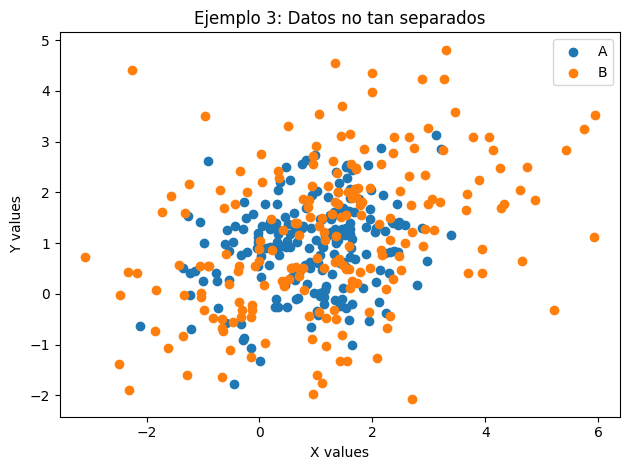

Magnitud del drift: 0.21250000000000002 
p_value: 0.0005071785052369228 
Es significativo? True


In [53]:
# Ejemplo 3: Datos no tan separados

# Instanciamos dos Conjuntos de datos ligeramente diferentes que vamos a visualizar
A= np.random.multivariate_normal(mean=(1,1), cov=((1.0, 0.3), (0.3, 1.0)), size=200)
B= np.random.multivariate_normal(mean=(1,1), cov=((3.0, 1.0), (1.0, 2.0)), size=200)

plt.figure()

plt.title("Ejemplo 3: Datos no tan separados")

plt.scatter(A[:,0], A[:,1], label="A")
plt.scatter(B[:,0], B[:,1], label="B")
plt.xlabel("X values")
plt.ylabel("Y values")
plt.legend()
plt.tight_layout()
plt.show()

# Y ahora calculamos el data drift entre ambos conjuntos
drift= ks_multidimensional_drift_computation(A, B)

# Lo detectará?

print(f"Magnitud del drift: {drift[0]} \np_value: {drift[1]} \nEs significativo? {drift[1] <= TRESHOLD}")